In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fretbursts import *
fname = 'photonHDF5/E3BD_GdmHCl_3M_14_05_15_2012.hdf5'  # for testing
fname = 'photonHDF5/E3BD_GdmHCl_3_5M_9_05_08_2012.hdf5'  # for testing
fname = '../Relevant BH measurements/lacCONS Cy3B Atto647N RNAP/photonHDF5/minus8TA_minus5NTD/minus8ta_minus5ntd_rpo_rt_1.hdf5'

In [4]:
# data_folder = 'data/E3BD smFRET #2/'
# filelist = [f for f in Path(data_folder).glob('*.hdf5') if not f.stem.endswith('_cache')]
# [x.stem for x in filelist]

In [2]:
fretmath.correct_S??

In [5]:
fname = Path(fname)
fname.is_file()

True

# Load data

In [6]:
d = loader.photon_hdf5(fname)

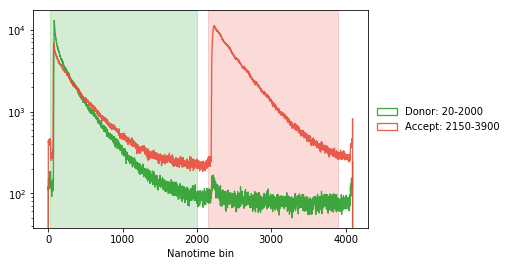

In [7]:
plot_alternation_hist(d)

In [8]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):     8,326,368
#  D  photons in D+A excitation periods:    2,119,231
#  A  photons in D+A excitation periods:    6,207,137
# D+A photons in  D  excitation period:     3,970,665
# D+A photons in  A  excitation period:     4,355,703



In [9]:
d.time_max

3605.43776745

In [10]:
d.acquisition_duration

array(3605.)

In [11]:
d.fname

'../Relevant BH measurements/lacCONS Cy3B Atto647N RNAP/photonHDF5/minus8TA_minus5NTD/minus8ta_minus5ntd_rpo_rt_1.hdf5'

In [12]:
ph = d.ph_times_m[0]
assert(np.diff(ph) >= 0).all()

# Timetraces

In [13]:
plot_interactive_timetrace = False

In [14]:
if plot_interactive_timetrace:
    from ipywidgets import interact, widgets
    import numpy as np

    from bokeh.io import push_notebook, show, output_notebook
    from bokeh.plotting import figure
    from bokeh.models import Range1d
    output_notebook()

In [15]:
if plot_interactive_timetrace:
    tmin = 0
    tmax = 600
    binwidth = 1e-3
    bins = np.arange(tmin, tmax + binwidth, binwidth)
    t = bins[:-1]
    y, bins = np.histogram(d.ph_times_m[0]*d.clk_p, bins=bins)

In [16]:
if plot_interactive_timetrace:
    width = 1000
    start = 0
    ymax = 80

    slider = widgets.FloatSlider(description='Time (s):', readout_format='.1f',
        value=start, min=0, max=(y.size - width)*binwidth, step=binwidth*width/2)
    slider.layout.width = '600px'
    def update(start=0):
        start /= binwidth
        stop = start + width
        s = slice(int(start), int(start + width))
        r.data_source.data['y'] = y[s]
        p.title.text = f'Timetrace: Time = {start*binwidth} s'
        push_notebook()

    p = figure(title="Timetrace: Time = 0", plot_height=300, plot_width=900,
               x_range=(0, 1), y_range=(0, ymax))
    p.xaxis.axis_label = 'Time (s)'
    p.yaxis.axis_label = 'Counts'
    s = slice(int(start), int(start + width))
    r = p.line(t[s], y[s], line_width=1)
    show(p, notebook_handle=True);

In [17]:
if plot_interactive_timetrace: interact(update, start=slider);

Here we plot a static set of timetraces distributed along the acquisition:

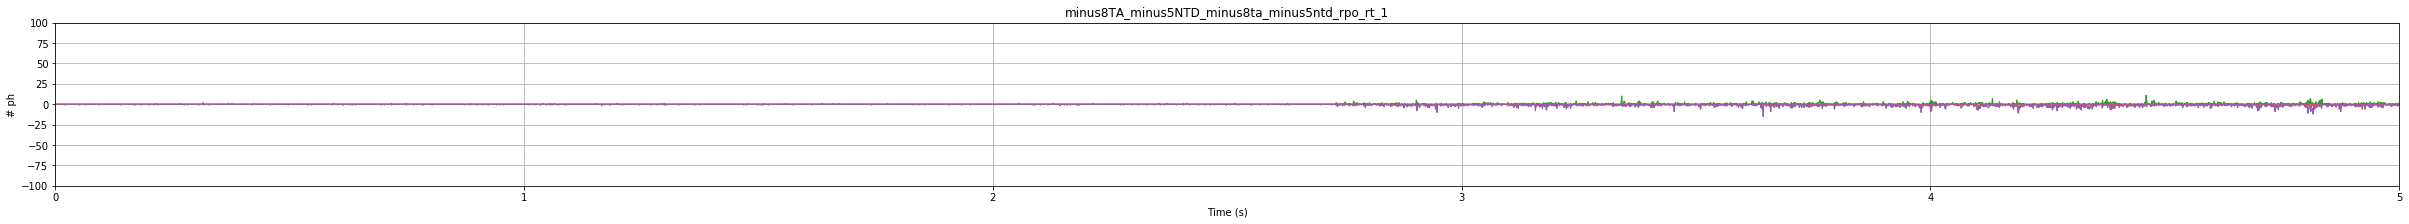

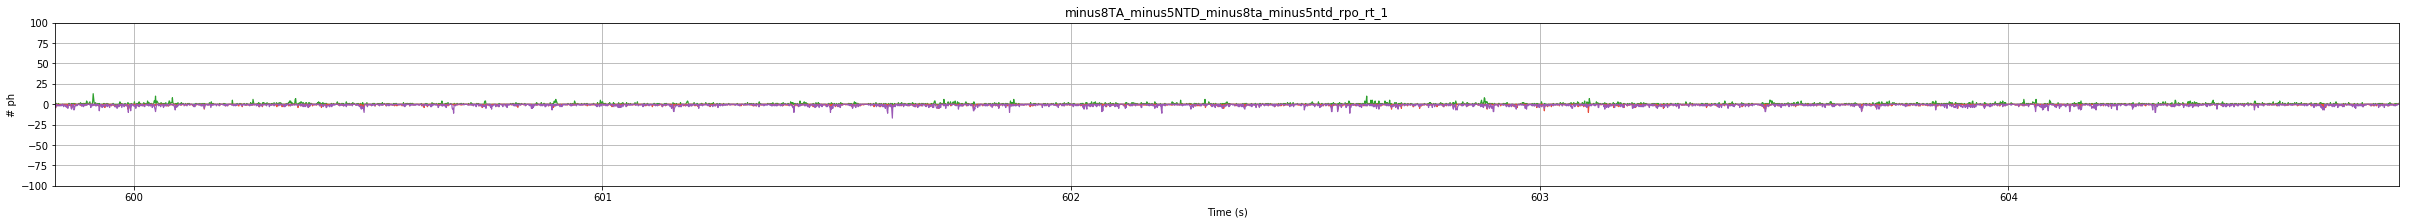

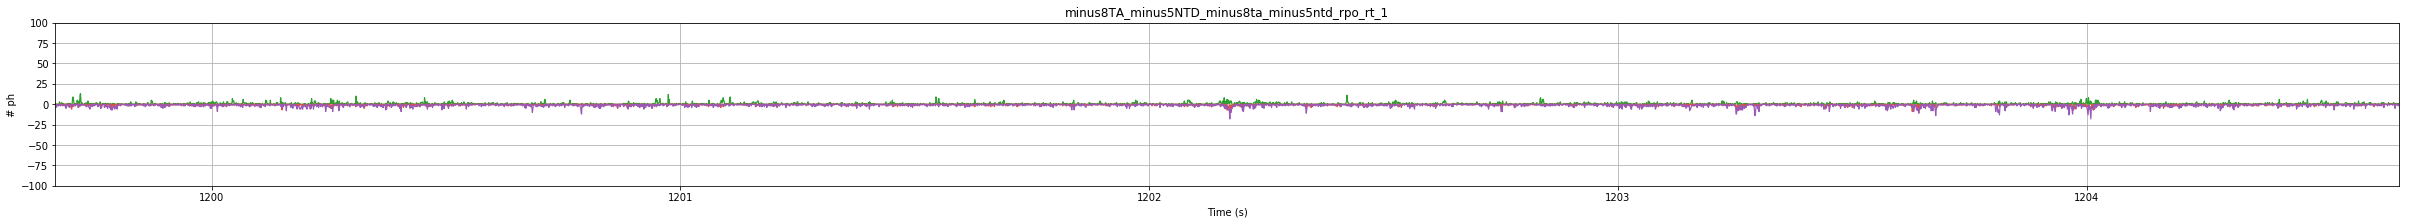

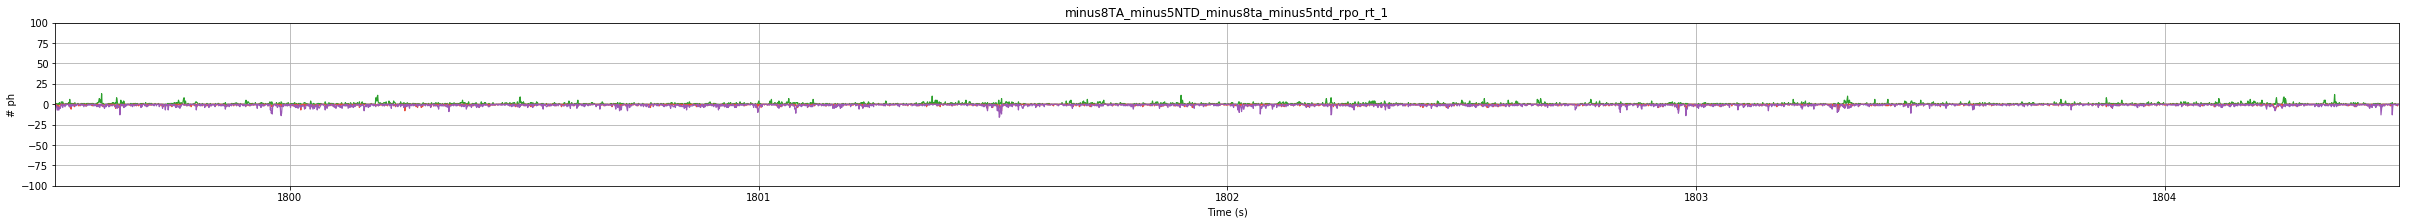

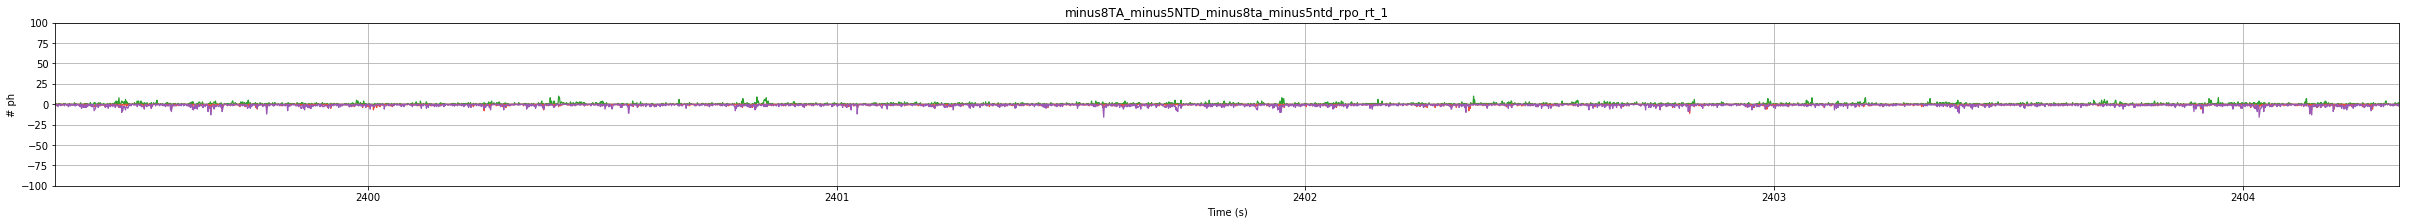

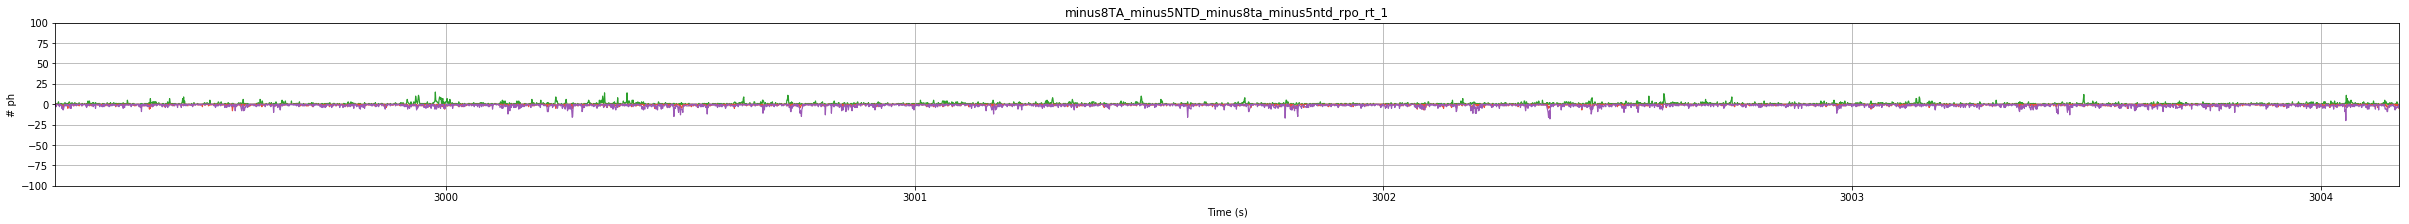

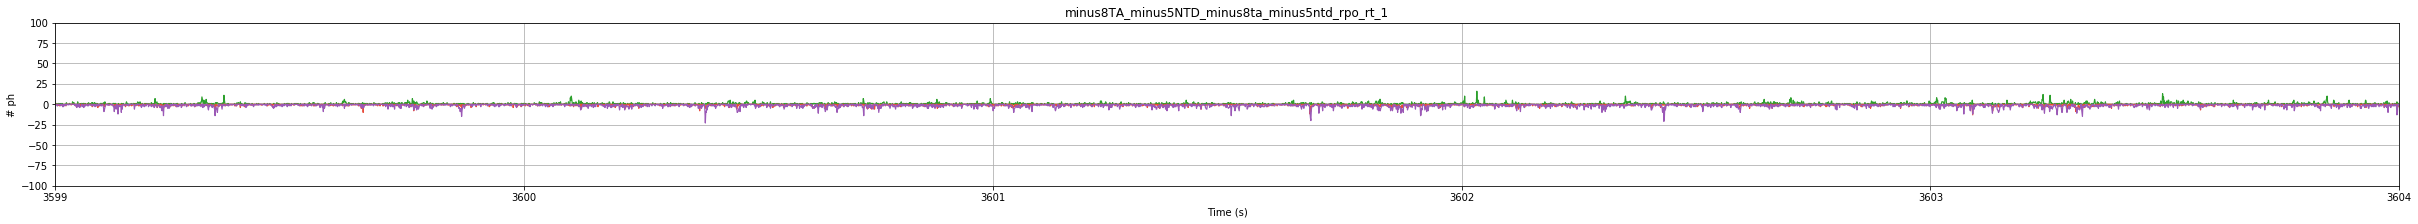

In [18]:
time_window = 5  # seconds
num_samples = 7  # number of time points (i.e. plots)
for i in np.linspace(0, np.int(d.time_max - time_window - 1), num_samples):
    fig, ax = plt.subplots(figsize=(42, 3))
    dplot(d, timetrace, tmin=i, tmax=i+time_window, ax=ax)
    plt.xlim(i, i + time_window)
    display(fig)
    plt.close('all')

# Background

In [19]:
d.calc_bg(bg.exp_fit, time_s=60, tail_min_us='auto')

 - Calculating BG rates ... [DONE]


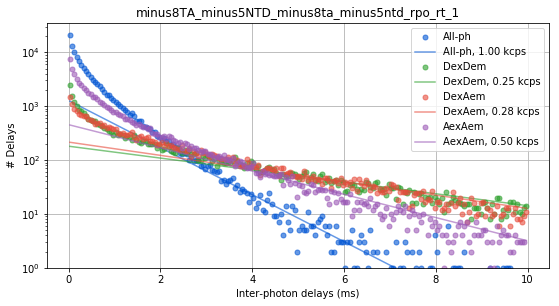

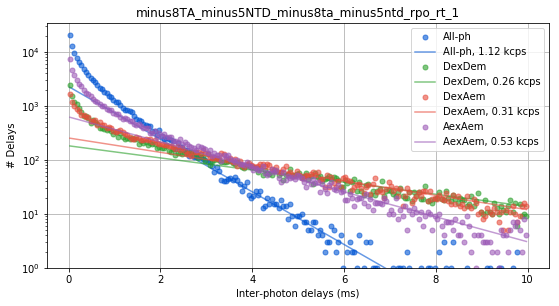

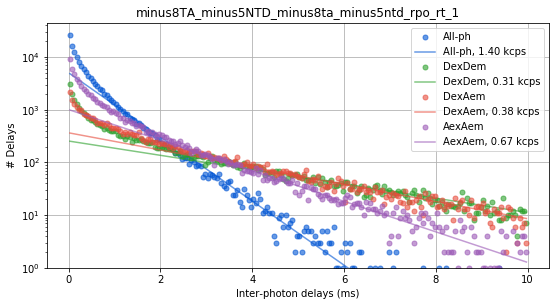

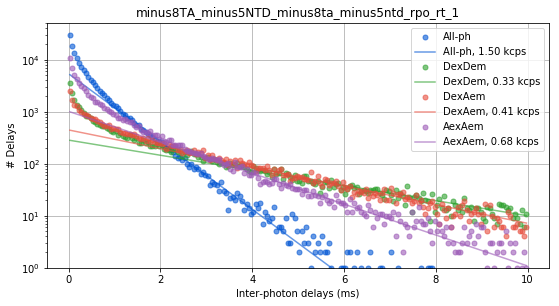

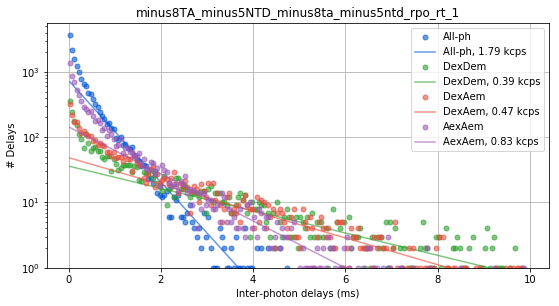

In [54]:
num_samples = 5
for period in np.linspace(0, d.nperiods-1, num_samples).astype(int):
    dplot(d, hist_bg, binwidth=5e-5, period=period)

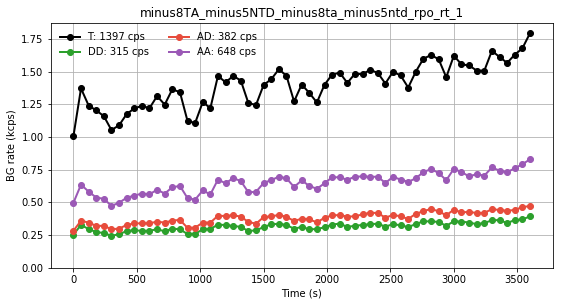

In [20]:
dplot(d, timetrace_bg)

# Burst search

In [21]:
bsearch_params = dict(m=10, F=6, ph_sel=Ph_sel(Dex='DAem'))
d.burst_search(**bsearch_params)
d.calc_max_rate(m=10)

df = d.fuse_bursts(0)
df.calc_max_rate(m=10)

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 12639 bursts (20.1%, 10 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


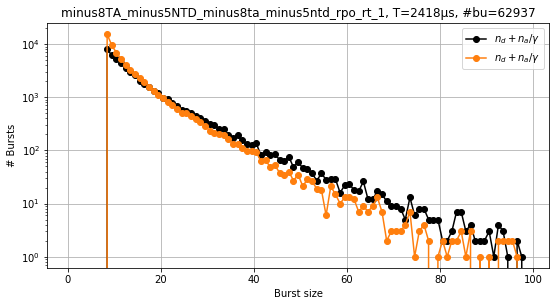

In [57]:
bins=(0, 100, 1)
dplot(df, hist_size, bins=bins);
dplot(d, hist_size, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });

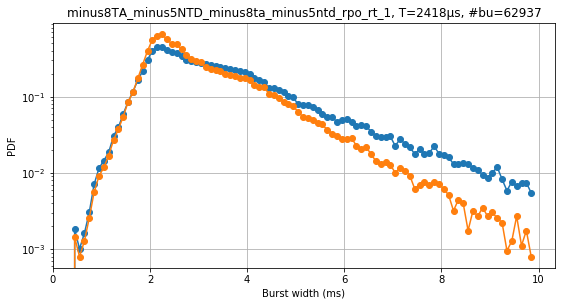

In [58]:
bins=(0, 10, 0.1)
dplot(df, hist_width, bins=bins);
dplot(d, hist_width, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });

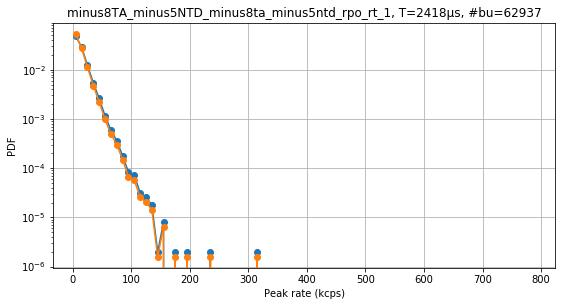

In [59]:
bins=(0, 800, 10)
dplot(df, hist_burst_phrate, bins=bins);
dplot(d, hist_burst_phrate, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });

# Burst selection

In [82]:
ds = d.select_bursts(select_bursts.size, th1=30)
ds = ds.select_bursts(select_bursts.naa, th1=30)

In [83]:
dsf = df.select_bursts(select_bursts.size, th1=30)
dsf = dsf.select_bursts(select_bursts.naa, th1=30)

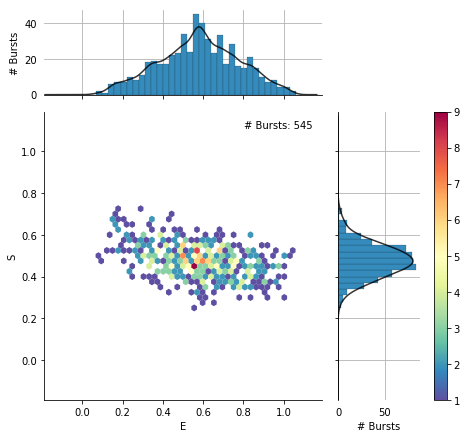

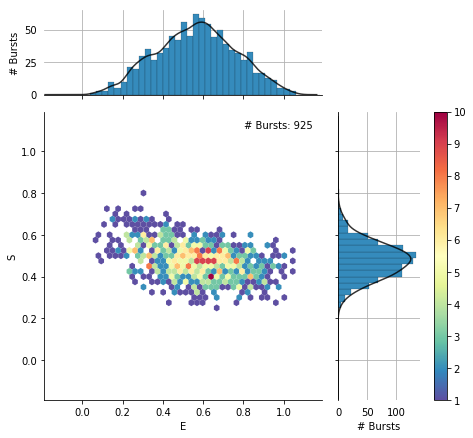

In [84]:
alex_jointplot(ds);
alex_jointplot(dsf);

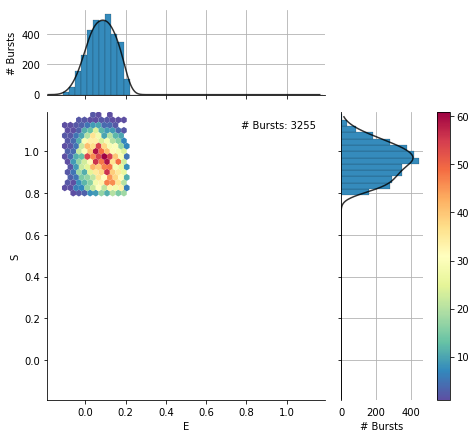

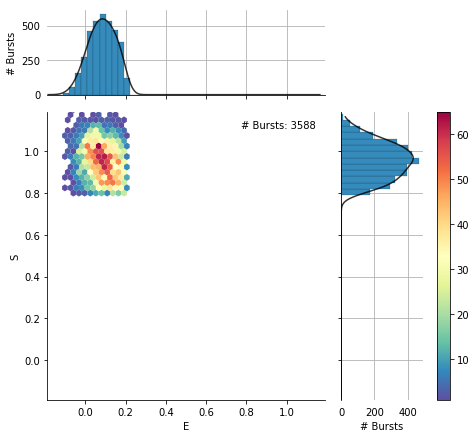

In [63]:
ds_do = d.select_bursts(select_bursts.size, add_naa=True, th1=20)
ds_do = ds_do.select_bursts(select_bursts.ES, S1=0.8, E2=0.2)

ds_dof = df.select_bursts(select_bursts.size, add_naa=True, th1=20)
ds_dof = ds_dof.select_bursts(select_bursts.ES, S1=0.8, E2=0.2)

alex_jointplot(ds_do, vmax_fret=False);
alex_jointplot(ds_dof, vmax_fret=False);

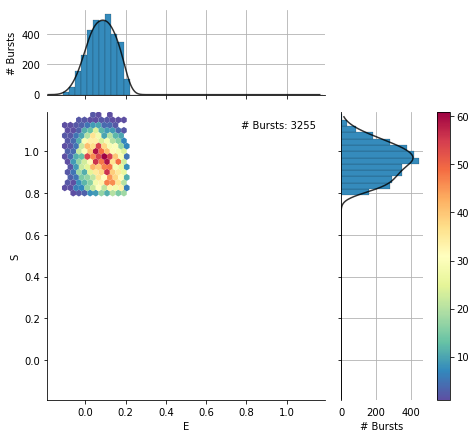

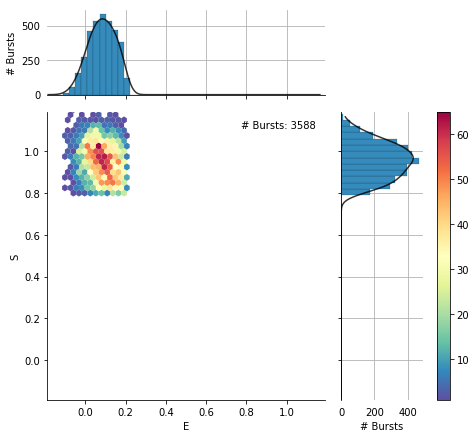

In [63]:
ds_aof = df.select_bursts(select_bursts.size, add_naa=True, th1=20)
ds_aof = ds_dof.select_bursts(select_bursts.ES, S2=0.25)

alex_jointplot(ds_aof, vmax_fret=False);

In [64]:
d.nanotimes_params

[{'tcspc_num_bins': 4096,
  'tcspc_range': 4.9999998976e-08,
  'tcspc_unit': 1.2207031e-11}]

In [65]:
def get_nanotimes(d, ph_sel):
    mask = d.ph_in_bursts_mask_ich(ph_sel=ph_sel)
    return d.nanotimes[0][mask]

In [66]:
tcspc_bin = d.nanotimes_params[0]['tcspc_unit']
tcspc_range = d.nanotimes_params[0]['tcspc_range']
tcspc_num_bins = d.nanotimes_params[0]['tcspc_num_bins']
bins_raw = np.arange(0, tcspc_num_bins)

ph_sel_d = Ph_sel(Dex='Dem')
ph_sel_a = Ph_sel(Dex='Aem')
nanotimes_d = get_nanotimes(d, ph_sel_d)
nanotimes_a = get_nanotimes(d, ph_sel_a)

hist_params = dict(bins=bins_raw, density=False)
nanot_hist_d, _ = np.histogram(nanotimes_d, **hist_params)
nanot_hist_a, _ = np.histogram(nanotimes_a, **hist_params)

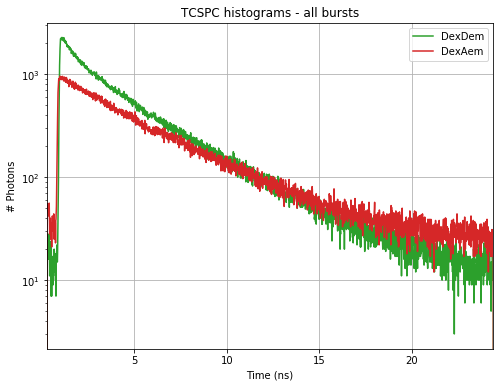

In [67]:
time_axis_ns = (bins_raw[1:] * tcspc_bin) * 1e9
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_axis_ns, nanot_hist_d, color='C2', label=str(ph_sel_d))
ax.plot(time_axis_ns, nanot_hist_a, color='C3', label=str(ph_sel_a))
ax.set_yscale('log')
ax.set_xlabel('Time (ns)');
ax.grid(True)
has_counts = np.where((nanot_hist_d + nanot_hist_a) > 0)[0]
ax.set_xlim(time_axis_ns[has_counts[0]], time_axis_ns[has_counts[-1]]);
ax.legend();
ax.set_title('TCSPC histograms - all bursts')
ax.set_ylabel('Probability' if hist_params['density'] else '# Photons');

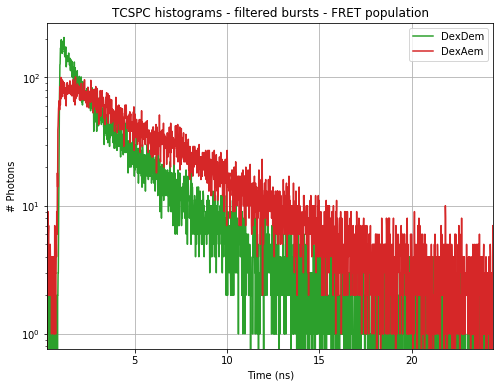

In [68]:
bins_raw = np.arange(0, tcspc_num_bins)
nanotimes_d = get_nanotimes(ds, ph_sel_d)
nanotimes_a = get_nanotimes(ds, ph_sel_a)

hist_params = dict(bins=bins_raw, density=False)
nanot_hist_d, _ = np.histogram(nanotimes_d, **hist_params)
nanot_hist_a, _ = np.histogram(nanotimes_a, **hist_params)

time_axis_ns = (bins_raw[1:] * tcspc_bin) * 1e9
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_axis_ns, nanot_hist_d, color='C2', label=str(ph_sel_d))
ax.plot(time_axis_ns, nanot_hist_a, color='C3', label=str(ph_sel_a))
ax.set_yscale('log')
ax.set_xlabel('Time (ns)');
ax.grid(True)
has_counts = np.where((nanot_hist_d + nanot_hist_a) > 0)[0]
ax.set_xlim(time_axis_ns[has_counts[0]], time_axis_ns[has_counts[-1]]);
ax.legend();
ax.set_title('TCSPC histograms - filtered bursts - FRET population')
ax.set_ylabel('Probability' if hist_params['density'] else '# Photons');

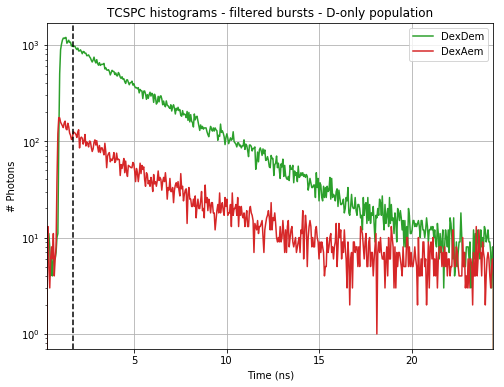

In [78]:
nt_th = 1.7
bins_raw = np.arange(0, tcspc_num_bins, 4)
nanotimes_d = get_nanotimes(ds_do, ph_sel_d)
nanotimes_a = get_nanotimes(ds_do, ph_sel_a)
nanotimes_d_ns = nanotimes_d * tcspc_bin * 1e9
donly_lifetime_ns = nanotimes_d_ns[nanotimes_d_ns > nt_th].mean() - nt_th
donly_lifetime_ns

hist_params = dict(bins=bins_raw, density=False)
nanot_hist_d, _ = np.histogram(nanotimes_d, **hist_params)
nanot_hist_a, _ = np.histogram(nanotimes_a, **hist_params)

time_axis_ns = (bins_raw[1:] * tcspc_bin) * 1e9
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_axis_ns, nanot_hist_d, color='C2', label=str(ph_sel_d))
ax.plot(time_axis_ns, nanot_hist_a, color='C3', label=str(ph_sel_a))
ax.set_yscale('log')
ax.set_xlabel('Time (ns)');
ax.grid(True)
has_counts = np.where((nanot_hist_d + nanot_hist_a) > 0)[0]
ax.set_xlim(time_axis_ns[has_counts[0]], time_axis_ns[has_counts[-1]]);
ax.legend();
ax.axvline(nt_th, ls='--', color='k')
ax.set_title('TCSPC histograms - filtered bursts - D-only population')
ax.set_ylabel('Probability' if hist_params['density'] else '# Photons');

In [79]:
donly_lifetime_ns

3.994921884782114

In [80]:
import fretbursts.fit.exp_fitting as ef

def compute_score(residuals, x_residuals, metric):
    """Compute score to test if a ECDF is from a given distribution.
    
    Arguments:
        residuals (array): difference between the empirical CDF and the model
            CDF.
        x_residuals (array): values where the ECF is computed. Same size as 
            `residuals`.
        metric (string): type of test statistics. Valid values are 
            'KS' for Kolgomorov-Smirnov, 'CM' for Cramer von Mises.
    """
    if metric not in ['KS', 'CM']:
        raise ValueError(f"Invalid `metric` argument ({metric}).\n"
                          "Valid values are 'KS' or 'CM'.")
    error = None
    if metric == 'KS':
        error = np.abs(residuals).max()*100
    elif metric == 'CM':
        error = np.trapz(residuals**2, x=x_residuals)
    return error

def get_score(samples, th):
    """Compute the exponentiality score of sample, for valuels > than `th`.
    """
    tail = samples[samples > th] - th
    tau_fit = tail.mean()
    x_residuals, residuals = ef.get_residuals(tail, tau_fit)
    score = compute_score(residuals, x_residuals, 'CM')
    return score, tau_fit, tail.size


def calc_scores(values, th_list):
    """
    """
    scores = np.zeros_like(th_list, dtype=float)
    taus = np.zeros_like(th_list, dtype=float)
    for i, th in enumerate(th_list):   
        scores[i], taus[i], _ = get_score(values, th)
    return scores, taus

def exp_from_hist(counts, bins, tau_th, tau_fit):
    """Compute an exponential curve fitting the tail of the input histogram.
    
    Arguments:
        counts (array): histograms counts
        bins (array): histogram bins, `bins` size is `counts.size + 1`.
        tau_th (float): threshold value where the exponential tail of the 
            histogram starts.
        tau_fit (float): decay constant of the exponentail function.
    """
    t = bins[:-1] + 0.5*(bins[1] -  bins[0])
    i_max = np.nonzero(counts > 0)[0][-1]  # index of last non-zero element
    i_tau_th = np.searchsorted(bins, tau_th)
    y_fit = np.exp(- t / tau_fit)
    y_fit *= counts[i_tau_th:].sum() / y_fit[i_tau_th:].sum()
    return t, y_fit

/opt/conda/miniconda3/envs/py36-sys/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice.
/opt/conda/miniconda3/envs/py36-sys/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

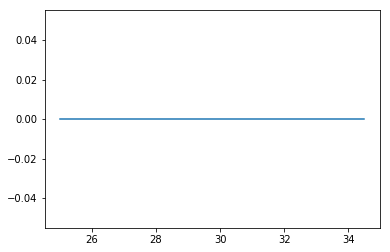

In [81]:
nt_th_list = np.arange(25, 35, 0.5)

scores, taus = calc_scores(nanotimes_d_ns, nt_th_list)
#score, tau_fit, ntail = get_score(values_c, Th_min)

fig, ax = plt.subplots()
ax.plot(nt_th_list, scores, label='score vs threshold')
ax.plot(nt_th, scores[nt_th_list == nt_th], 'ok', 
        label=f'Score = {scores.min():.1e} @ th = {nt_th:.1f} ns')
ax.set_ylabel('Score (AU)')
ax.set_xlabel('Threshold (ns)')
ax.set_title('Exponentiality score and fit value vs threshold')
ax2 = plt.twinx()
ax2.plot(nt_th_list, taus, color='C1', label='Estimated lifetime')
ax2.plot(nt_th, donly_lifetime_ns, 'oC1')
ax2.set_ylabel('Mean lifetime (ns)')
ax2.axhspan(donly_lifetime_ns*0.99, donly_lifetime_ns*1.01, color='C1', alpha=0.1,
            label=rf'Fit $\pm$ 1% @ th = {nt_th} ns')
ax2.legend(loc=(1.08, 0));
ax2.set_ylim(3)
ax.legend(loc=(1.08, 0.9));
ax.axvline(nt_th, color='k', ls='--')
ax2.grid(True)

time_axis_ns = (bins_raw[1:] * tcspc_bin) * 1e9
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_axis_ns, nanot_hist_d, color='C2', label=str(ph_sel_d))
ax.set_yscale('log')
ax.set_xlabel('Time (ns)');
ax.grid(True)
has_counts = np.where((nanot_hist_d + nanot_hist_a) > 0)[0]
ax.set_xlim(time_axis_ns[has_counts[0]], time_axis_ns[has_counts[-1]]);
ax.axvline(nt_th, ls='--', color='k')
t, y_fit = exp_from_hist(nanot_hist_d, bins_raw*tcspc_bin*1e9, nt_th, donly_lifetime_ns)
ax.plot(t, y_fit, '-k', label=f'τ = {donly_lifetime_ns:.2f} ns using th = {nt_th} ns')
ax.set_ylim(1e-1, nanot_hist_d.max()*1.5)
ax.legend();
ax.set_title('TCSPC histograms - filtered bursts - D-only population')
ax.set_ylabel('Probability' if hist_params['density'] else '# Photons');

# Save bursts

In [ ]:
bursts_fnameF = Path(fname.parents[1], 'results', fname.stem + '_FRET_bursts.csv')
bursts_fnameF

In [ ]:
bursts = bext.burst_data(dsf, include_bg=True)

In [ ]:
bursts

In [ ]:
bursts.to_csv(bursts_fnameF)

In [ ]:
bursts_fnameD = Path(fname.parents[1], 'results', fname.stem + '_Donly_bursts.csv')
bursts_fnameD

In [ ]:
burstsD = bext.burst_data(ds_dof, include_bg=True)

In [ ]:
burstsD

In [ ]:
burstsD.to_csv(bursts_fnameD)

# Save burst photons

## Put burst photons in a DataFrame

In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
# stream_map = {0: 'DexDem', 1: 'DexAem', 2: 'AexDem', 3: 'AexAem'}
# stream_dtype = CategoricalDtype(categories=stream_map.values())
# stream_dtype

In [ ]:
def phdata_df_to_list(burstph):
    """Return a list of "photon data" DataFrame, each containing one burst.
    """
    burstph_list = []
    for burst, df in burstph.groupby('burst'):
        burstph_list.append(df.reset_index('burst', drop=True))
    return burstph_list


def phdata_list_to_df(burstph_list):
    """Return a single "photon data" DataFrame containing all bursts.
    """
    burstph = pd.concat(burstph_list, keys=np.arange(len(burstph_list)), 
                        names=['burst'])
    return burstph

### FRET population

In [ ]:
burstph = bext.burst_photons(dsf)
burstph.timestamp -= d.ph_times_m[0][0]

In [ ]:
burstph.groupby('stream').count()

In [ ]:
ich = 0
times_arr = np.hstack(
        bl.iter_bursts_ph(dsf.ph_times_m[ich], dsf.mburst[ich]))
times_arr[-1] * 50e-9

In [ ]:
3600 / 50e-9 * 1e-9

In [ ]:
d.ph_times_m[0][0]

In [ ]:
burstph.timestamp

In [ ]:
(burstph.timestamp.diff()[1:] == 0).sum()

In [ ]:
# Tests
x_list = phdata_df_to_list(burstph)
burstph2 = phdata_list_to_df(x_list)
assert (burstph2 == burstph).all().all()

### D-only population

In [ ]:
#burstphD = get_burst_photon(ds_do)
burstphD = bext.burst_photons(ds_dof)
burstphD.timestamp -= d.ph_times_m[0][0]

## Save burst photons to disk

In [ ]:
burst_photons_fnameF = Path(fname.parents[1], 'results', fname.stem + '_FRET_burst_photons.csv')
burst_photons_fnameF

In [ ]:
import json

In [ ]:
meta = dict(
    description="photon data for FRET bursts in a measurement",
    datafile=fname.stem,
    timestamp_unit=float(d.clk_p),
    nanotime_unit=tcspc_bin,
    donly_lifetime=donly_lifetime_ns)

In [ ]:
meta

In [ ]:
with open(burst_photons_fnameF, mode='wt') as f:
    json.dump(meta, f)
    f.write('\n')
    burstph.to_csv(f)

In [ ]:
burst_photons_fnameD = Path(fname.parents[1], 'results', fname.stem + '_Donly_burst_photons.csv')
burst_photons_fnameD

In [ ]:
meta['description'] = meta['description'].replace('FRET', 'D-only')

In [ ]:
with open(burst_photons_fnameD, mode='wt') as f:
    json.dump(meta, f)
    f.write('\n')
    burstphD.to_csv(f)

## Read the file back

In [ ]:
burstph2 = pd.read_csv(burst_photons_fnameF, skiprows=1, index_col=(0, 1))
#burstph2.stream.astype(stream_dtype);

In [ ]:
assert (burstph2 == burstph).all().all()

In [ ]:
header = burst_photons_fnameF.read_text().split('\n')[0]
burstph2.meta = json.loads(header)
burstph2.meta

In [ ]:
burstph.head()

In [ ]:
burstphD2 = pd.read_csv(burst_photons_fnameD, skiprows=1, index_col=(0, 1))
#burstphD2.stream.astype(stream_dtype);

In [ ]:
assert (burstphD2 == burstphD).all().all()

In [ ]:
header = burst_photons_fnameD.read_text().split('\n')[0]
burstphD2.meta = json.loads(header)
burstphD2.meta

# BVA

In [ ]:
d.burst_search(m=10, computefret=False, ph_sel=Ph_sel(Dex='DAem'))
d.calc_fret(count_ph=True, corrections=False)

In [ ]:
ds1 = d.select_bursts(select_bursts.size, th1=20, computefret=False)
ds = ds1.select_bursts(select_bursts.naa, th1=20, computefret=False)
ds_FRET = ds#ds1.select_bursts(select_bursts.S, S1=0.25, S2=0.85, computefret=False)

In [ ]:
alex_jointplot(ds_FRET)

# Burst Variance Analysis

In [ ]:
import seaborn as sns

We define a function to compute $s_E$:

In [ ]:
def bva_sigma_E(n, bursts, DexAem_mask, out=None):
    """
    Perform BVA analysis computing std.dev. of E for sub-bursts in each burst.
    
    Split each burst in n-photons chunks (sub-bursts), compute E for each sub-burst,
    then compute std.dev. of E across the sub-bursts.

    For details on BVA see:

    - Torella et al. (2011) Biophys. J. doi.org/10.1016/j.bpj.2011.01.066
    - Ingargiola et al. (2016) bioRxiv, doi.org/10.1101/039198

    Arguments:
        n (int): number of photons in each sub-burst
        bursts (Bursts object): burst-data object with indexes relative 
            to the Dex photon stream.
        DexAem_mask (bool array): mask of A-emitted photons during D-excitation 
            periods. It is a boolean array indexing the array of Dex timestamps 
            (`Ph_sel(Dex='DAem')`).
        out (None or list): append the result to the passed list. If None,
            creates a new list. This is useful to accumulate data from
            different spots in a single list.

    Returns:
        E_sub_std (1D array): contains for each burst, the standard deviation of 
        sub-bursts FRET efficiency. Same length of input argument `bursts`.
    """
    E_sub_std = [] if out is None else out
    
    for burst in bursts:
        E_sub_bursts = []
        startlist = range(burst.istart, burst.istop + 2 - n, n)
        stoplist = [i + n for i in startlist]
        for start, stop in zip(startlist, stoplist):
            A_D = DexAem_mask[start:stop].sum()
            assert stop - start == n
            E = A_D / n
            E_sub_bursts.append(E)
        E_sub_std.append(np.std(E_sub_bursts))
        
    return E_sub_std

Next we prepare the data for BVA:

In [ ]:
ph_d = ds_FRET.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
bursts = ds_FRET.mburst[0]
bursts_d = bursts.recompute_index_reduce(ph_d)

In [ ]:
Dex_mask = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))   
DexAem_mask = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='Aem')) 
DexAem_mask_d = DexAem_mask[Dex_mask]

and call the `bva_sigma_E` function:

In [ ]:
n = 5
E_sub_std = bva_sigma_E(n, bursts_d, DexAem_mask_d)

Finally, we make a KDE plot of the 2D distribution `E_sub_std` versus the burst FRET efficiency:

In [ ]:
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
plt.plot(x, y, lw=2, color='k', ls='--')
im = sns.kdeplot(ds_FRET.E[0], np.asfarray(E_sub_std), 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(0,1)
plt.ylim(0,np.sqrt(0.5**2/7)*2)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\sigma_i$', fontsize=16);
plt.text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=plt.gca().transAxes)
plt.text(0.95, 0.95, '# Bursts: %d' % ds_FRET.num_bursts, 
         va='top', ha='right', transform=plt.gca().transAxes)

In [ ]:
x, y = ds_FRET.E[0], np.asfarray(E_sub_std)
hist_kws = dict(edgecolor='k', linewidth=0.2,
                facecolor=sns.color_palette('Spectral_r', 100)[10])

g = sns.JointGrid(x=x, y=y, ratio=3)
g.plot_joint(sns.kdeplot, cmap='Spectral_r', shade=True, shade_lowest=False, n_levels=20)
g.ax_marg_x.hist(x, bins=np.arange(-0.2, 1.2, 0.025), **hist_kws)
g.ax_marg_y.hist(y, bins=50, orientation="horizontal", **hist_kws)

x1 = np.arange(0,1.01,0.01)
y1 = np.sqrt((x1*(1-x1))/n)
plt.plot(x1, y1, lw=2, color='k', ls='--')

g.ax_joint.set_xlim(0,1)
g.ax_joint.set_ylim(0,np.sqrt(0.5**2/7)*2)
g.ax_joint.set_xlabel('E', fontsize=16)
g.ax_joint.set_ylabel(r'$\sigma_i$', fontsize=16);
g.ax_joint.text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=g.ax_joint.transAxes)
g.ax_joint.text(0.95, 0.95, '# Bursts: %d' % ds_FRET.num_bursts, 
         va='top', ha='right', transform=g.ax_joint.transAxes)